# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 20: Black Litterman with Factors Models Mean Risk Optimization

## 1. Downloading the data:

In [1]:
########################################################################
# Uploading Data
########################################################################

import pandas as pd
import numpy as np

# Interest Rates Data
kr = pd.read_excel('KeyRates.xlsx', engine='openpyxl', index_col=0, header=0)/100

# Prices  Data
assets = pd.read_excel('Assets.xlsx', engine='openpyxl', index_col=0, header=0)

# Find common dates
a = pd.merge(left=assets, right=kr, how='inner', on='Date')
dates = a.index

# Calculate interest rates returns
kr_returns = kr.loc[dates,:].sort_index().diff().dropna()
kr_returns.sort_index(ascending=False, inplace=True)

# List of instruments
equity = ['APA','CMCSA','CNP','HPQ','PSA','SEE','ZION']
bonds = ['PEP11900D031', 'PEP13000D012', 'PEP13000M088',
         'PEP23900M103','PEP70101M530','PEP70101M571',
         'PEP70310M156']
factors = ['MTUM','QUAL','SIZE','USMV','VLUE']

# Calculate assets returns
assets_returns = assets.loc[dates, equity + bonds]
assets_returns = assets_returns.sort_index().pct_change().dropna()
assets_returns.sort_index(ascending=False, inplace=True)

# Calculate factors returns
factors_returns = assets.loc[dates, factors]
factors_returns = factors_returns.sort_index().pct_change().dropna()
factors_returns.sort_index(ascending=False, inplace=True)

# Show tables
display(kr_returns.head().style.format("{:.4%}"))
display(assets_returns.head().style.format("{:.4%}"))

,0,90,180,360,720,1800,3600,7200,10800
Date,,,,,,,,,
2017-11-16 00:00:00,0.0000%,0.0059%,0.0108%,0.0178%,0.0246%,0.0213%,0.0075%,-0.0048%,-0.0093%
2017-11-15 00:00:00,0.0180%,0.0247%,0.0303%,0.0391%,0.0495%,0.0558%,0.0512%,0.0450%,0.0417%
2017-11-14 00:00:00,-0.1800%,-0.1710%,-0.1624%,-0.1460%,-0.1167%,-0.0506%,0.0140%,0.0676%,0.0861%
2017-11-13 00:00:00,0.0000%,0.0013%,0.0025%,0.0048%,0.0088%,0.0174%,0.0258%,0.0334%,0.0364%
2017-11-10 00:00:00,0.0000%,0.0026%,0.0043%,0.0054%,0.0017%,-0.0248%,-0.0615%,-0.0936%,-0.1054%


,APA,CMCSA,CNP,HPQ,PSA,SEE,ZION,PEP11900D031,PEP13000D012,PEP13000M088,PEP23900M103,PEP70101M530,PEP70101M571,PEP70310M156
Date,,,,,,,,,,,,,,
2017-11-16 00:00:00,-1.3161%,-0.2958%,-1.0903%,0.9831%,1.7234%,1.4016%,-0.8387%,-0.0411%,-0.0380%,-0.0597%,-0.0737%,-0.0116%,0.0076%,-0.0633%
2017-11-15 00:00:00,-2.0296%,0.8682%,-1.1202%,0.0000%,-1.3479%,-0.3326%,0.0215%,-0.1626%,-0.3076%,-0.3041%,-0.2286%,-0.4459%,-0.4651%,-0.2146%
2017-11-14 00:00:00,-3.7020%,-1.0470%,1.0800%,0.8975%,-0.1548%,0.2668%,2.6950%,0.2320%,0.0236%,0.1040%,0.2373%,-0.2741%,-0.3932%,0.2151%
2017-11-13 00:00:00,-1.4503%,1.0855%,0.7480%,-0.2826%,0.8179%,1.4205%,3.4145%,0.0906%,0.0064%,-0.0767%,0.0354%,-0.0835%,-0.1114%,-0.0081%
2017-11-10 00:00:00,-2.4536%,0.7932%,-1.3418%,-0.5155%,0.0710%,-0.9381%,-0.0910%,0.1194%,0.3792%,0.3047%,0.1355%,0.7118%,0.8207%,-0.0090%


In [2]:
########################################################################
# Uploading Duration and Convexity Matrixes
########################################################################

durations = pd.read_excel('durations.xlsx', index_col=0, header=0)
convexity = pd.read_excel('convexity.xlsx', index_col=0, header=0)

print('Durations Matrix')
display(durations.head().style.format("{:.4f}").background_gradient(cmap='YlGn'))
print('')
print('Convexities Matrix')
display(convexity.head().style.format("{:.4f}").background_gradient(cmap='YlGn'))

Durations Matrix


,R 0,R 90,R 180,R 360,R 720,R 1800,R 3600,R 7200,R 10800
PEP11900D031,0.0012,0.0057,0.0192,0.0730,0.3685,3.0416,0.0030,0.0000,0.0000
PEP13000D012,0.0000,0.0078,0.0142,0.0617,0.3327,1.0902,4.8055,0.2074,0.0000
PEP13000M088,0.0013,0.0004,0.0147,0.0501,0.2770,2.4626,3.0764,0.0000,0.0000
PEP23900M103,0.0000,0.0005,0.0117,0.0405,0.2274,3.9726,0.0381,0.0000,0.0000
PEP70101M530,0.0000,0.0052,0.0101,0.0442,0.2488,0.8826,4.9147,3.5537,0.0000



Convexities Matrix


,R^2 0,R^2 90,R^2 180,R^2 360,R^2 720,R^2 1800,R^2 3600,R^2 7200,R^2 10800
PEP11900D031,0.0004,0.0032,0.0167,0.0928,0.7741,15.5617,0.0000,0.0000,0.0000
PEP13000D012,0.0000,0.0057,0.0070,0.0756,0.7210,4.4984,45.2159,0.1105,0.0000
PEP13000M088,0.0010,0.0001,0.0192,0.0736,0.6161,8.8479,16.2880,0.0000,0.0000
PEP23900M103,0.0000,0.0000,0.0156,0.0644,0.5161,22.1272,0.0022,0.0000,0.0000
PEP70101M530,0.0000,0.0038,0.0052,0.0561,0.5530,3.7373,38.2315,26.1464,0.0000


## 2. Estimating Black Litterman with Factors for Fixed Income Portfolios

### 2.1 Building the loadings matrix and risk factors returns

This part shows how to build a personalized loadings matrix that will be used by Riskfolio-Lib to calculate the expected returns and covariance matrix.

In [3]:
########################################################################
# Building The Loadings Matrix
########################################################################

loadings = pd.concat([-1.0 * durations, 0.5 * convexity], axis = 1)

display(loadings.style.format("{:.4f}").background_gradient(cmap='YlGn'))

,R 0,R 90,R 180,R 360,R 720,R 1800,R 3600,R 7200,R 10800,R^2 0,R^2 90,R^2 180,R^2 360,R^2 720,R^2 1800,R^2 3600,R^2 7200,R^2 10800
PEP11900D031,-0.0012,-0.0057,-0.0192,-0.0730,-0.3685,-3.0416,-0.0030,-0.0000,-0.0000,0.0002,0.0016,0.0083,0.0464,0.3871,7.7809,0.0000,0.0000,0.0000
PEP13000D012,-0.0000,-0.0078,-0.0142,-0.0617,-0.3327,-1.0902,-4.8055,-0.2074,-0.0000,0.0000,0.0029,0.0035,0.0378,0.3605,2.2492,22.6080,0.0553,0.0000
PEP13000M088,-0.0013,-0.0004,-0.0147,-0.0501,-0.2770,-2.4626,-3.0764,-0.0000,-0.0000,0.0005,0.0000,0.0096,0.0368,0.3081,4.4240,8.1440,0.0000,0.0000
PEP23900M103,-0.0000,-0.0005,-0.0117,-0.0405,-0.2274,-3.9726,-0.0381,-0.0000,-0.0000,0.0000,0.0000,0.0078,0.0322,0.2581,11.0636,0.0011,0.0000,0.0000
PEP70101M530,-0.0000,-0.0052,-0.0101,-0.0442,-0.2488,-0.8826,-4.9147,-3.5537,-0.0000,0.0000,0.0019,0.0026,0.0280,0.2765,1.8686,19.1157,13.0732,0.0000
PEP70101M571,-0.0015,-0.0039,-0.0126,-0.0501,-0.2829,-1.0108,-2.5878,-6.0312,-0.4501,0.0002,0.0016,0.0064,0.0319,0.3123,2.1336,10.1632,49.9021,0.4523
PEP70310M156,-0.0000,-0.0039,-0.0097,-0.0403,-0.2614,-3.8920,-0.0000,-0.0000,-0.0000,0.0000,0.0010,0.0030,0.0268,0.2508,10.6813,0.0000,0.0000,0.0000


In [4]:
########################################################################
# Building the risk factors returns matrix
########################################################################

kr_returns_2 =  kr_returns ** 2
cols = loadings.columns

X = pd.concat([kr_returns, kr_returns_2], axis=1)
X.columns = cols

display(X.head().style.format("{:.4%}"))

,R 0,R 90,R 180,R 360,R 720,R 1800,R 3600,R 7200,R 10800,R^2 0,R^2 90,R^2 180,R^2 360,R^2 720,R^2 1800,R^2 3600,R^2 7200,R^2 10800
Date,,,,,,,,,,,,,,,,,,
2017-11-16 00:00:00,0.0000%,0.0059%,0.0108%,0.0178%,0.0246%,0.0213%,0.0075%,-0.0048%,-0.0093%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2017-11-15 00:00:00,0.0180%,0.0247%,0.0303%,0.0391%,0.0495%,0.0558%,0.0512%,0.0450%,0.0417%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2017-11-14 00:00:00,-0.1800%,-0.1710%,-0.1624%,-0.1460%,-0.1167%,-0.0506%,0.0140%,0.0676%,0.0861%,0.0003%,0.0003%,0.0003%,0.0002%,0.0001%,0.0000%,0.0000%,0.0000%,0.0001%
2017-11-13 00:00:00,0.0000%,0.0013%,0.0025%,0.0048%,0.0088%,0.0174%,0.0258%,0.0334%,0.0364%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2017-11-10 00:00:00,0.0000%,0.0026%,0.0043%,0.0054%,0.0017%,-0.0248%,-0.0615%,-0.0936%,-0.1054%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0001%,0.0001%


In [5]:
########################################################################
# Building the asset returns matrix
########################################################################

Y = assets_returns[bonds]

display(Y.head())

,PEP11900D031,PEP13000D012,PEP13000M088,PEP23900M103,PEP70101M530,PEP70101M571,PEP70310M156
Date,,,,,,,
2017-11-16,-0.000411,-0.000380,-0.000597,-0.000737,-0.000116,0.000076,-0.000633
2017-11-15,-0.001626,-0.003076,-0.003041,-0.002286,-0.004459,-0.004651,-0.002146
2017-11-14,0.002320,0.000236,0.001040,0.002373,-0.002741,-0.003932,0.002151
2017-11-13,0.000906,0.000064,-0.000767,0.000354,-0.000835,-0.001114,-0.000081
2017-11-10,0.001194,0.003792,0.003047,0.001355,0.007118,0.008207,-0.000090


### 2.2 Building views on risk factors

In [6]:
########################################################################
# Showing annualized returns of Fixed Income Risk Factors
########################################################################

display(X.mean()*252)

R 0         -0.002028
R 90        -0.001955
R 180       -0.001819
R 360       -0.001463
R 720       -0.000791
R 1800      -0.000530
R 3600      -0.002041
R 7200      -0.003312
R 10800     -0.003533
R^2 0        0.000173
R^2 90       0.000080
R^2 180      0.000049
R^2 360      0.000038
R^2 720      0.000046
R^2 1800     0.000050
R^2 3600     0.000057
R^2 7200     0.000069
R^2 10800    0.000091
dtype: float64

In [7]:
########################################################################
# Building views on some Risk Factors
########################################################################

views = {'Disabled': [False, False, False],
        'Factor': ['R 10800','R 1800','R 3600'],
        'Sign': ['>=', '<=', '<='],
        'Value': [0.001, -0.001, -0.003],
        'Relative Factor': ['R 7200', '', '']}

views = pd.DataFrame(views)

display(views)

,Disabled,Factor,Sign,Value,Relative Factor
0,False,R 10800,>=,0.001,R 7200
1,False,R 1800,<=,-0.001,
2,False,R 3600,<=,-0.003,


In [8]:
########################################################################
# Building views matrixes P_f and Q_f
########################################################################

import riskfolio.ConstraintsFunctions as cf

P_f, Q_f = cf.factors_views(views, loadings, const=False)

print('Matrix of factors views P_f')
print(P_f)
print('\nMatrix of returns of factors views Q_f')
print(Q_f)

Matrix of factors views P_f
[[ 0  0  0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]]

Matrix of returns of factors views Q_f
[[0.001]
 [0.001]
 [0.003]]


### 2.3 Building Portfolios with mean vector and covariance matrix from Black Litterman with Factors.

In [9]:
########################################################################
# Building the Portfolio Object
########################################################################

import riskfolio.Portfolio as pf

# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

port.factors = X
port.factors_stats(method_mu=method_mu, method_cov=method_cov, d=0.94, B=loadings)

In [10]:
########################################################################
# Calculating optimum portfolios using Mean Vector and
# Covariance Matrix of Black Litterman with Factors
########################################################################

port.alpha = 0.05
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # False: BL covariance and risk factors scenarios
         # True: historical covariance and scenarios
         # 2: risk factors covariance and scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_fm = port.optimization(model='FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist) 

# Estimate Portfolio weights using Black Litterman Bayesian Model:
port.blfactors_stats(flavor='BLB',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=False,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_blb = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# Estimate Portfolio weights using Augmented Black Litterman Model:
port.blfactors_stats(flavor='ABL',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=False,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_abl = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

ws = pd.concat([w_fm, w_blb, w_abl], axis=1)
ws.columns = ['Pure Factors', 'Bayesian BL', 'Augmented BL']

display(ws.style.format("{:.4%}").background_gradient(cmap='YlGn'))

You must convert self.cov_bl_fm to a positive definite matrix
You must convert self.cov_bl_fm to a positive definite matrix


,Pure Factors,Bayesian BL,Augmented BL
PEP11900D031,0.0000%,0.0000%,0.0002%
PEP13000D012,6.6666%,33.1357%,85.2545%
PEP13000M088,0.0000%,0.0000%,0.0004%
PEP23900M103,0.0000%,0.0000%,0.0002%
PEP70101M530,32.3836%,0.0000%,14.7441%
PEP70101M571,60.9498%,66.8643%,0.0004%
PEP70310M156,0.0000%,0.0000%,0.0002%


We can see that the we got a messsage that the covariance matrix is not a positive definite matrix, this is common when we work with views on assets or risk factors. In this case, Riskfolio-Lib replace the negative eigenvalues of covariance matrix with zeros and reconstruct the covariance matrix. The problem with this approach is common that the weights that we will get are highly concetrated in few assets.

Other approach is using the mean vector estimated with Black Litterman with Factors and the covariance matrix that we get from historical returns or a factor model. An example with this approach follows:

### 2.4 Building Portfolios with mean vector from Black Litterman with Factors.

In [11]:
########################################################################
# Calculating optimum portfolios using only Mean Vector
# of Black Litterman with Factors and Factor Covariance Matrix
########################################################################

hist = 2 # False: BL covariance and risk factors scenarios
             # True: historical covariance and scenarios
             # 2: risk factors covariance and scenarios (Only in BL_FM)

# Estimate Portfolio weights using Black Litterman Bayesian Model:
port.blfactors_stats(flavor='BLB',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=False,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_blb = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# Estimate Portfolio weights using Augmented Black Litterman Model:
port.blfactors_stats(flavor='ABL',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=False,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_abl = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

ws = pd.concat([w_fm, w_blb, w_abl], axis=1)
ws.columns = ['Pure Factors', 'Bayesian BL', 'Augmented BL']

display(ws.style.format("{:.4%}").background_gradient(cmap='YlGn'))

You must convert self.cov_bl_fm to a positive definite matrix
You must convert self.cov_bl_fm to a positive definite matrix


,Pure Factors,Bayesian BL,Augmented BL
PEP11900D031,0.0000%,0.0000%,6.1659%
PEP13000D012,6.6666%,16.6284%,16.4517%
PEP13000M088,0.0000%,2.2787%,5.2876%
PEP23900M103,0.0000%,0.0000%,11.2159%
PEP70101M530,32.3836%,35.1621%,26.2782%
PEP70101M571,60.9498%,45.9306%,23.8401%
PEP70310M156,0.0000%,0.0000%,10.7607%


We can see that when we only use the mean vector of Black Litterman with Factors, the weights that we get are more diversified. Also, we can see that the Augmented Black Litterman creates more diversified portfolios than the Bayesian Black Litterman.

## 3. Estimating Mean Variance Portfolio for Equity and Fixed Income Portfolio

### 3.1 Building the loadings matrix and risk factors returns.

This part shows how to build a personalized loadings matrix that will be used by Riskfolio-Lib to calculate the expected returns and covariance matrix.

In [12]:
import riskfolio.ParamsEstimation as pe

B = pe.loadings_matrix(factors_returns, assets_returns[equity])

display(B.style.format("{:.4f}").background_gradient(cmap='YlGn'))

,const,MTUM,QUAL,SIZE,USMV,VLUE
APA,-0.0008,-0.8999,1.2674,0.0000,-0.5750,1.4874
CMCSA,-0.0000,0.2426,0.0000,-0.1569,0.5483,0.3623
CNP,-0.0001,-0.3827,-0.3579,0.0000,1.9556,0.0000
HPQ,0.0003,0.0000,0.5164,0.0000,0.0000,0.7550
PSA,-0.0000,0.0000,-0.4623,0.0000,1.8071,-0.3115
SEE,-0.0001,0.0000,0.4915,0.0000,0.5043,0.2535
ZION,0.0002,0.0000,1.1589,0.0000,-1.3203,1.2202


In [13]:
########################################################################
# Building the asset returns matrix
########################################################################

Y = pd.concat([assets_returns[equity], Y], axis=1)

display(Y.head())

,APA,CMCSA,CNP,HPQ,PSA,SEE,ZION,PEP11900D031,PEP13000D012,PEP13000M088,PEP23900M103,PEP70101M530,PEP70101M571,PEP70310M156
Date,,,,,,,,,,,,,,
2017-11-16,-0.013161,-0.002958,-0.010903,0.009831,0.017234,0.014016,-0.008387,-0.000411,-0.000380,-0.000597,-0.000737,-0.000116,0.000076,-0.000633
2017-11-15,-0.020296,0.008682,-0.011202,0.000000,-0.013479,-0.003326,0.000215,-0.001626,-0.003076,-0.003041,-0.002286,-0.004459,-0.004651,-0.002146
2017-11-14,-0.037020,-0.010470,0.010800,0.008975,-0.001548,0.002668,0.026950,0.002320,0.000236,0.001040,0.002373,-0.002741,-0.003932,0.002151
2017-11-13,-0.014503,0.010855,0.007480,-0.002826,0.008179,0.014205,0.034145,0.000906,0.000064,-0.000767,0.000354,-0.000835,-0.001114,-0.000081
2017-11-10,-0.024536,0.007932,-0.013418,-0.005155,0.000710,-0.009381,-0.000910,0.001194,0.003792,0.003047,0.001355,0.007118,0.008207,-0.000090


In [14]:
########################################################################
# Building the asset returns matrix
########################################################################

X = pd.concat([factors_returns, X], axis=1)

display(X.head())

,MTUM,QUAL,SIZE,USMV,VLUE,R 0,R 90,R 180,R 360,R 720,...,R 10800,R^2 0,R^2 90,R^2 180,R^2 360,R^2 720,R^2 1800,R^2 3600,R^2 7200,R^2 10800
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-16,0.009478,0.007556,0.006675,0.006408,0.014509,0.00000,0.000059,0.000108,0.000178,0.000246,...,-0.000093,0.000000e+00,3.527647e-09,1.163831e-08,3.181621e-08,6.048648e-08,4.552420e-08,5.573518e-09,2.314283e-09,8.695936e-09
2017-11-15,-0.003381,-0.005884,-0.001974,-0.006750,-0.003771,0.00018,0.000247,0.000303,0.000391,0.000495,...,0.000417,3.225005e-08,6.082093e-08,9.197391e-08,1.529780e-07,2.448864e-07,3.108575e-07,2.620815e-07,2.025117e-07,1.736147e-07
2017-11-14,-0.001687,0.000375,-0.000370,0.001932,-0.004380,-0.00180,-0.001710,-0.001624,-0.001460,-0.001167,...,0.000861,3.241235e-06,2.925701e-06,2.636999e-06,2.131988e-06,1.362113e-06,2.555747e-07,1.966922e-08,4.572289e-07,7.417774e-07
2017-11-13,0.002488,0.000877,0.003589,0.003296,0.000751,0.00000,0.000013,0.000025,0.000048,0.000088,...,0.000364,0.000000e+00,1.681950e-10,6.400900e-10,2.324301e-09,7.748577e-09,3.033345e-08,6.657174e-08,1.116368e-07,1.328391e-07
2017-11-10,0.002894,0.001255,-0.001730,-0.000968,0.001254,0.00000,0.000026,0.000043,0.000054,0.000017,...,-0.001054,0.000000e+00,6.770924e-10,1.820644e-09,2.881542e-09,2.791573e-10,6.131368e-08,3.779975e-07,8.759856e-07,1.110697e-06


In [15]:
########################################################################
# Building The Loadings Matrix
########################################################################

loadings = pd.concat([B, loadings], axis = 1)
loadings.fillna(0, inplace=True)

display(loadings.style.format("{:.4f}").background_gradient(cmap='YlGn'))

,const,MTUM,QUAL,SIZE,USMV,VLUE,R 0,R 90,R 180,R 360,R 720,R 1800,R 3600,R 7200,R 10800,R^2 0,R^2 90,R^2 180,R^2 360,R^2 720,R^2 1800,R^2 3600,R^2 7200,R^2 10800
APA,-0.0008,-0.8999,1.2674,0.0000,-0.5750,1.4874,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CMCSA,-0.0000,0.2426,0.0000,-0.1569,0.5483,0.3623,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CNP,-0.0001,-0.3827,-0.3579,0.0000,1.9556,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
HPQ,0.0003,0.0000,0.5164,0.0000,0.0000,0.7550,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
PSA,-0.0000,0.0000,-0.4623,0.0000,1.8071,-0.3115,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
SEE,-0.0001,0.0000,0.4915,0.0000,0.5043,0.2535,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ZION,0.0002,0.0000,1.1589,0.0000,-1.3203,1.2202,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
PEP11900D031,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0012,-0.0057,-0.0192,-0.0730,-0.3685,-3.0416,-0.0030,-0.0000,-0.0000,0.0002,0.0016,0.0083,0.0464,0.3871,7.7809,0.0000,0.0000,0.0000
PEP13000D012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0078,-0.0142,-0.0617,-0.3327,-1.0902,-4.8055,-0.2074,-0.0000,0.0000,0.0029,0.0035,0.0378,0.3605,2.2492,22.6080,0.0553,0.0000
PEP13000M088,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0013,-0.0004,-0.0147,-0.0501,-0.2770,-2.4626,-3.0764,-0.0000,-0.0000,0.0005,0.0000,0.0096,0.0368,0.3081,4.4240,8.1440,0.0000,0.0000


### 3.2 Building views on risk factors

In [16]:
########################################################################
# Showing annualized returns of Equity Risk Factors
########################################################################

display(factors_returns.mean()*252)

MTUM    0.154379
QUAL    0.113842
SIZE    0.115915
USMV    0.124555
VLUE    0.106612
dtype: float64

In [17]:
########################################################################
# Building views on some Risk Factors
########################################################################

views = {'Disabled': [False, False, False, False, False, False],
        'Factor': ['MTUM','USMV','SIZE','R 10800','R 1800','R 3600'],
        'Sign': ['>=', '>=', '>=', '>=', '<=', '<='],
        'Value': [0.02, 0.09, 0.12, 0.001, -0.001, -0.003],
        'Relative Factor': ['VLUE', '', '','R 90', '', '']}
views = pd.DataFrame(views)

display(views)

,Disabled,Factor,Sign,Value,Relative Factor
0,False,MTUM,>=,0.020,VLUE
1,False,USMV,>=,0.090,
2,False,SIZE,>=,0.120,
3,False,R 10800,>=,0.001,R 90
4,False,R 1800,<=,-0.001,
5,False,R 3600,<=,-0.003,


In [18]:
########################################################################
# Building views matrixes P_f and Q_f
########################################################################

P_f, Q_f = cf.factors_views(views, loadings, const=True)

print('Matrix of factors views P_f')
print(P_f)
print('\nMatrix of returns of factors views Q_f')
print(Q_f)

Matrix of factors views P_f
[[ 1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]]

Matrix of returns of factors views Q_f
[[0.02 ]
 [0.09 ]
 [0.12 ]
 [0.001]
 [0.001]
 [0.003]]


### 3.3 Building Portfolios with mean vector and covariance matrix from Black Litterman with Factors.

In [19]:
########################################################################
# Building Portfolio Object
########################################################################

# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  d=0.94)

port.factors = X
port.factors_stats(method_mu=method_mu,
                   method_cov=method_cov,
                   d=0.94,
                   B=loadings,
                   const=True)

In [20]:
########################################################################
# Calculating optimum portfolios
########################################################################

port.alpha = 0.05
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # False: BL covariance and risk factors scenarios
             # True: historical covariance and scenarios
             # 2: risk factors covariance and scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_fm = port.optimization(model='FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist) 

# Estimate Portfolio weights using Black Litterman Bayesian Model:
port.blfactors_stats(flavor='BLB',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=True,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_blb = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# Estimate Portfolio weights using Augmented Black Litterman Model:
port.blfactors_stats(flavor='ABL',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=True,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_abl = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

ws = pd.concat([w_fm, w_blb, w_abl], axis=1)
ws.columns = ['Pure Factors', 'Bayesian BL', 'Augmented BL']

display(ws.style.format("{:.4%}").background_gradient(cmap='YlGn'))

You must convert self.cov_bl_fm to a positive definite matrix
You must convert self.cov_bl_fm to a positive definite matrix


/Users/danycajas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/moment_helpers.py:251: RuntimeWarning: invalid value encountered in sqrt
  std_ = np.sqrt(np.diag(cov))


,Pure Factors,Bayesian BL,Augmented BL
APA,0.0000%,0.0000%,0.0000%
CMCSA,10.6667%,0.0000%,0.0000%
CNP,12.2571%,0.0000%,0.0000%
HPQ,16.3689%,54.3495%,72.8467%
PSA,26.0443%,5.2034%,0.0000%
SEE,0.0767%,0.0000%,0.0000%
ZION,7.9948%,0.0000%,0.0000%
PEP11900D031,0.0000%,40.4471%,0.0000%
PEP13000D012,0.0000%,0.0000%,27.1529%
PEP13000M088,0.0000%,0.0000%,0.0000%


We can see that the we got a messsage that the covariance matrix is not a positive definite matrix, this is common when we work with views on assets or risk factors. In this case, Riskfolio-Lib replace the negative eigenvalues of covariance matrix with zeros and reconstruct the covariance matrix. The problem with this approach is common that the weights that we will get are highly concetrated in few assets.

Other approach is using the mean vector estimated with Black Litterman with Factors and the covariance matrix that we get from historical returns or a factor model.

### 3.4 Building Portfolios with mean vector from Black Litterman with Factors.

In [21]:
########################################################################
# Calculating optimum portfolios
########################################################################

hist = 2 # False: BL covariance and risk factors scenarios
         # True: historical covariance and scenarios
         # 2: risk factors covariance and scenarios (Only in BL_FM)

# Estimate Portfolio weights using Black Litterman Bayesian Model:
port.blfactors_stats(flavor='BLB',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=True,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_blb = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# Estimate Portfolio weights using Augmented Black Litterman Model:
port.blfactors_stats(flavor='ABL',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=True,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

w_abl = port.optimization(model='BL_FM', rm=rm, obj=obj, rf=rf, l=l, hist=hist)

ws = pd.concat([w_fm, w_blb, w_abl], axis=1)
ws.columns = ['Pure Factors', 'Bayesian BL', 'Augmented BL']

display(ws.style.format("{:.4%}").background_gradient(cmap='YlGn'))

You must convert self.cov_bl_fm to a positive definite matrix
You must convert self.cov_bl_fm to a positive definite matrix


,Pure Factors,Bayesian BL,Augmented BL
APA,0.0000%,0.0000%,0.0000%
CMCSA,10.6667%,0.0000%,7.3146%
CNP,12.2571%,0.0000%,1.6698%
HPQ,16.3689%,10.8421%,21.2752%
PSA,26.0443%,13.2860%,12.0815%
SEE,0.0767%,0.0000%,0.0000%
ZION,7.9948%,5.0666%,20.9109%
PEP11900D031,0.0000%,70.8053%,2.3390%
PEP13000D012,0.0000%,0.0000%,6.3644%
PEP13000M088,0.0000%,0.0000%,2.0302%


We can see that when we only use the mean vector of Black Litterman with Factors, the weights that we get are more diversified. Also, we can see that the Augmented Black Litterman creates more diversified portfolios than the Bayesian Black Litterman.

## 4. Estimating Black Litterman with Factors Mean Risk Portfolios

When we use risk measures different than Standard Deviation, Riskfolio-Lib only considers the vector of expected returns, and use historical returns to calculate risk measures.

### 4.1 Calculate Black Litterman Bayesian Portfolios for Several Risk Measures

In [22]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])
port.alpha = 0.05

port.blfactors_stats(flavor='BLB',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=True,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

model = 'BL_FM'
obj = 'Sharpe'

for i in rms:
    if i == 'MV':
        hist = 2
    else:
        hist = True
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

You must convert self.cov_bl_fm to a positive definite matrix


/Users/danycajas/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [23]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CMCSA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,4.07%,0.45%,3.37%,0.00%
CNP,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.31%,0.00%
HPQ,10.84%,3.17%,14.69%,2.95%,14.79%,16.12%,16.77%,17.21%,9.18%,1.24%,0.43%,0.84%,3.58%
PSA,13.29%,4.53%,19.30%,4.92%,19.49%,22.07%,25.69%,28.31%,40.57%,28.83%,36.63%,30.88%,39.43%
SEE,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,3.97%,5.97%,0.00%,5.75%,0.11%
ZION,5.07%,2.95%,7.52%,3.22%,7.57%,12.43%,6.94%,0.00%,3.62%,9.54%,9.38%,9.58%,7.50%
PEP11900D031,70.81%,89.35%,58.50%,88.91%,58.14%,49.39%,50.60%,54.47%,42.68%,50.36%,53.10%,49.28%,49.38%
PEP13000D012,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PEP13000M088,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


<AxesSubplot:>

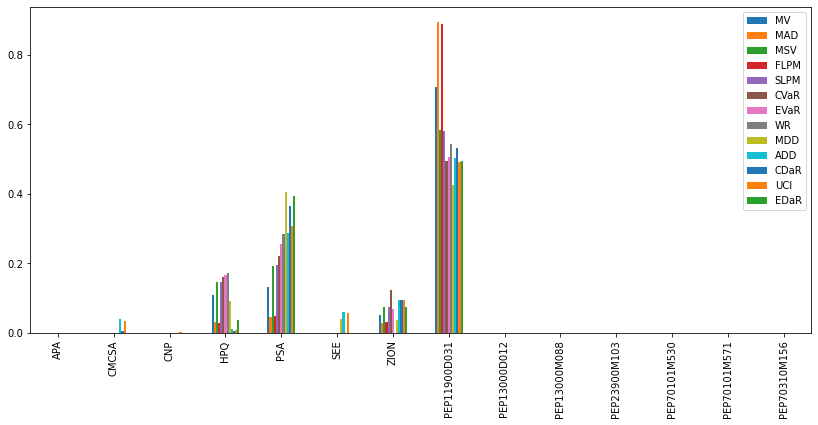

In [24]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

### 4.2 Calculate Augmented Black Litterman Portfolios for Several Risk Measures

In [25]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])
port.alpha = 0.05

port.blfactors_stats(flavor='ABL',
                     B=loadings,
                     P_f=P_f,
                     Q_f=Q_f/252,
                     rf=0,
                     delta=None,
                     eq=True,
                     const=True,
                     diag=False,
                     method_mu=method_mu,
                     method_cov=method_cov)

model = 'BL_FM'
obj = 'Sharpe'

for i in rms:
    if i == 'MV':
        hist = 2
    else:
        hist = True
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

You must convert self.cov_bl_fm to a positive definite matrix


In [26]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CMCSA,7.31%,7.34%,8.79%,6.38%,8.88%,8.36%,8.79%,5.47%,6.11%,15.07%,5.27%,11.85%,7.29%
CNP,1.67%,3.53%,0.00%,2.67%,0.00%,0.00%,0.00%,0.00%,18.42%,4.20%,25.33%,10.06%,20.55%
HPQ,21.28%,22.38%,19.00%,24.95%,18.78%,16.58%,15.88%,14.88%,13.48%,3.41%,6.93%,1.57%,10.91%
PSA,12.08%,15.68%,15.84%,15.57%,15.77%,15.63%,7.81%,0.00%,38.43%,31.22%,41.50%,34.67%,41.70%
SEE,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,7.49%,12.88%,4.78%,11.08%,7.66%
ZION,20.91%,17.88%,18.28%,18.92%,18.22%,17.27%,15.12%,14.63%,6.48%,13.10%,13.29%,14.57%,10.48%
PEP11900D031,2.34%,6.29%,0.00%,3.83%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PEP13000D012,6.36%,15.62%,19.18%,15.37%,19.39%,25.39%,24.55%,18.52%,0.00%,0.00%,0.00%,0.00%,0.00%
PEP13000M088,2.03%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,9.59%,0.00%,0.00%,0.00%,0.00%


<AxesSubplot:>

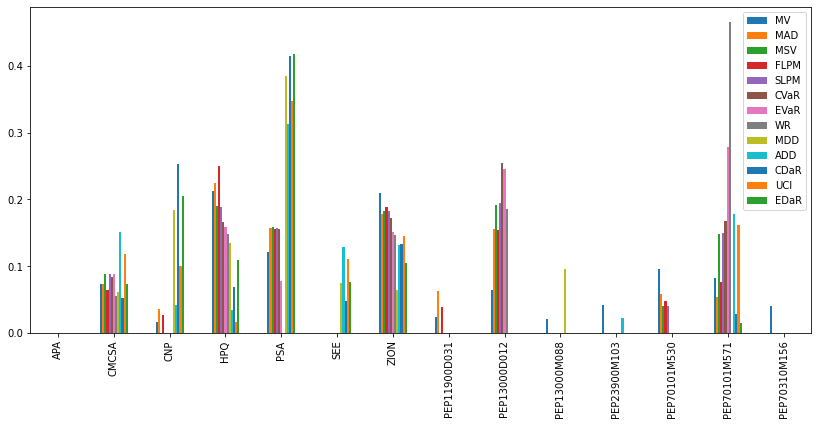

In [27]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

We can see that in the studied cases, the Augmented Black Litterman model increase the diversification in higher degree than Bayesian Black Litterman model.